# Tackling MNIST with just Numpy 

### Installing dependecies
Note: Tensorflow is imported here so that we can easily get the mnist dataset. 

In [224]:
import pandas as pd
import numpy as np
from tensorflow import keras # Keras is only imported as its an easy way to retrieve the mnist dataset.
import matplotlib.pyplot as plt

### Loading Data and preprocessing

In [225]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
print (f'x_train shape: {x_train.shape}')
print (f'x_test shape: {x_test.shape}')
print (f'y_train shape: {y_train.shape}')
print (f'y_test shape: {y_test.shape}')

print (f'y_train example: {y_train[0]}')

x_train shape: (60000, 28, 28)
x_test shape: (10000, 28, 28)
y_train shape: (60000,)
y_test shape: (10000,)
y_train example: 5


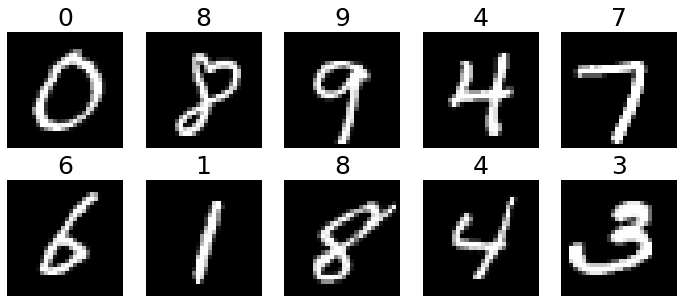

In [226]:
%matplotlib inline

fig, axes = plt.subplots(2,5, figsize=(12,5))
axes = axes.flatten()
idx = np.random.randint(0,60000,size=10)
for i in range(10):
    axes[i].imshow(x_train[idx[i],:].reshape(28,28), cmap='gray')
    axes[i].axis('off') # hide the axes ticks
    axes[i].set_title(str(int(y_train[idx[i]])), color= 'black', fontsize=25)
plt.show()

In [227]:
'''
Each pixel is single grayscale, meaning a value between 0 to 255.
Normalising the inputs to a value between 0 to 1 makes the calculations later on smaller.
This makes the gradient value closer to our weight initialization 
'''

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])
x_train = x_train/255
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])
x_test = x_test/255

def one_hot_encode_array(y:np.array):
    '''Hot encodes the output examples.'''
    hot_encoded = np.zeros([y.shape[0],10 ])
    for i, x in enumerate(y):
        hot_encoded[i][x] = 1
    return hot_encoded

y_train = one_hot_encode_array(y_train)
y_test = one_hot_encode_array(y_test)

In [228]:
def relu(x):
    x[x < 0] = 0
    return x


def softmax(x):
    """
    Compute the softmax of vector x in a numerically stable way.
    Softmax is an interesting function.
    Please read https://eli.thegreenplace.net/2016/the-softmax-function-and-its-derivative/ for an indepth analysis on it and its derivatives.
    """
    shiftx = x - np.max(x, axis=0)
    exps = np.exp(shiftx)
    return exps / np.sum(exps, axis=0)


def forward_pass(a_0, w_1, w_2):
    # Layer 1
    z_1 = w_1 @ a_0  #   N1 x 784 * 784 x m  = N1 x m
    a_1 = relu(z_1)  #  N1 x m

    # Layer 2
    z_2 = w_2 @ a_1  #  10 x N1 * N1 x m  = 10 x m
    a_2 = softmax(z_2)  # 10 x m
    return z_1, a_1, z_2, a_2


def d_relu(x):
    diag = x>0
    return np.diag(diag.flatten())


def d_softmax(z):
    """Computes the gradient of the softmax function.
    z: (T, 1) array of input values where the gradient is computed. T is the
       number of output classes.
    Returns D (T, T) the Jacobian matrix of softmax(z) at the given z. D[i, j]
    is DjSi - the partial derivative of Si w.r.t. input j.
    """
    Sz = softmax(z)
    # -SjSi can be computed using an outer product between Sz and itself. Then
    # we add back Si for the i=j cases by adding a diagonal matrix with the
    # values of Si on its diagonal.
    D = -np.outer(Sz, Sz) + np.diag(Sz.flatten())
    return D


def cross_entropy_loss(a_2, y):
    """Cross-entropy loss between predicted and expected probabilities.
    p: vector of predicted probabilities.
    y: vector of expected probabilities. Has to be the same shape as p.
    Returns a scalar.
    """
    assert a_2.shape == y.shape
    eps = 1e-30
    return - np.sum(y * np.log(a_2+eps))


def d_cross_entropy_loss(a_2, y):
    """Gradient of the cross-entropy loss function for p and y.
    p: (T, 1) vector of predicted probabilities.
    y: (T, 1) vector of expected probabilities; must be one-hot -- one and only
              one element of y is 1; the rest are 0.
    Returns a (1, T) Jacobian for this function.
    """
    assert a_2.shape == y.shape and a_2.shape[1] == 1
    # py is the value of p at the index where y == 1 (one and only one such
    # index is expected for a one-hot y).
    py = a_2[y == 1]
    assert py.size == 1
    # D is zeros everywhere except at the index where y == 1. The final D has
    # to be a row-vector.
    D = np.zeros_like(a_2)
    if py.flat[0] == 0:
        py.flat[0] = 1e-30
    D[y == 1] = -1 / (py.flat[0])
    return D.flatten().reshape(-1, 1)
    


def backward_pass(a_0, z_1, a_1, z_2, a_2, w_1, w_2, Y):
    # Backward pass, differenciate wrt Cost function.
    d_a2 = d_cross_entropy_loss(a_2, Y)  # 10 x m
    d_z2 = d_a2.T @ d_softmax(z_2) # 10 x m * 10 x 10 = m x 10
    d_w2 = d_z2.T @ a_1.T  # 10 x m * m * N1 = 10 x N1

    d_a1 = w_2.T @ d_z2.T  # N1 x 10  * 10 x m  = N1 x m
    d_z1 = d_a1.T @ d_relu(z_1)  # m x N1 *  N1 x N1 = N1 x m
    d_w1 = d_z1.T @ a_0.T  # N1 x m * m x 784 = N1 x 784

    assert d_w1.shape == w_1.shape, f"{d_w1.shape} {w_1.shape}"
    assert d_w2.shape == w_2.shape, f"{d_w2.shape} {w_2.shape}"

    return d_w1, d_w2


def update_weights(w_1, w_2, d_w1, d_w2, learning_rate):
    w_1 = w_1 - learning_rate * d_w1
    w_2 = w_2 - learning_rate * d_w2
    return w_1, w_2


In [229]:
def gradient_descent(X, Y, w_1, w_2 , epochs = 1, learning_rate=0.001):
    loss = []
    for i in range(epochs):
        for x,y in zip(X, Y):
            a_0 = x.reshape(-1,1)
            y = y.reshape(-1,1)
            z_1, a_1, z_2 ,a_2 = forward_pass(a_0, w_1, w_2)
            loss.append(cross_entropy_loss(a_2,y))
            d_w1 , d_w2 = backward_pass(a_0, z_1,a_1, z_2 ,a_2, w_1,w_2, y)
            w_1, w_2 = update_weights(w_1,w_2, d_w1,d_w2,learning_rate)

    return w_1,w_2,loss

def get_prediction(a_2):
    return np.argmax(a_2.T)

def check_accuracy(X,Y ,w_1,w_2):
    a_0 = X.T
    z_1, a_1, z_2 ,a_2 = forward_pass(a_0, w_1, w_2)
    print(np.argmax(a_2[:10], axis=0))
    print(np.argmax(Y.T[:10],axis=0))

    accuracy = 1 - np.count_nonzero(np.argmax(Y.T,axis=0)- np.argmax(a_2, axis=0))/len(Y)
    return accuracy

In [230]:
neurons = 256
epochs = 2
learning_rate = 0.0001
w_1 = np.random.rand(neurons,784)
w_2 = np.random.rand(10, neurons)

In [231]:
w_1,w_2,loss = gradient_descent(x_train, y_train, w_1, w_2, epochs, learning_rate)

ValueError: shapes (1,10) and (1,256) not aligned: 10 (dim 1) != 1 (dim 0)

In [ ]:
# Plots the average loss
loss_sample = [ np.mean(loss[i: i+500]) for i,x in enumerate(loss) if i % 500 == 0 ]
plt.plot(loss_sample)
plt.show()

In [ ]:
accuracy = check_accuracy(x_test,y_test,w_1,w_2)
accuracy